## Uplift-моделирование

In [17]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, auc

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Пример данных
data = pd.DataFrame({
    'user_id': [1, 2, 3, 4, 5, 6],
    'treatment': [1, 0, 1, 0, 1, 0],
    'num_trips': [10, 8, 12, 7, 9, 6],
    'avg_trip_cost': [15, 12, 14, 11, 13, 10],
    'gender': ['M', 'F', 'M', 'F', 'M', 'F'],
    'location': ['City A', 'City B', 'City A', 'City B', 'City A', 'City B'],
    'target': [5, 2, 7, 1, 4, 0]
})

# Трансформация целевой переменной
data['target_transformed'] = data.apply(
    lambda row: row['target'] if row['treatment'] == 1 else -row['target'], axis=1)

In [3]:
# Целевая переменная и признаки
y = data['target_transformed']
X = data.drop(['target', 'target_transformed', 'user_id'], axis=1)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Предобработка данных
numeric_features = ['num_trips', 'avg_trip_cost']
categorical_features = ['gender', 'location']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])


In [4]:
# Модель
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Обучение модели
model.fit(X_train, y_train)

# Оценка модели
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Predictions:", y_pred)

Mean Squared Error: 1.6202
Predictions: [ 4.98 -0.2 ]


In [5]:
# Применение модели ко всем данным
all_data_predictions = model.predict(X)

# Устанавливаем пороговое значение для предоставления скидок
threshold = 1.0  

# Определение пользователей, которым рекомендуется предоставить скидку
data['predicted_uplift'] = all_data_predictions
data['give_discount'] = data['predicted_uplift'] > threshold

# Вывод пользователей, которым рекомендуется предоставить скидку
users_to_give_discount = data[data['give_discount']]

print("Users to give discount:")
print(users_to_give_discount[['user_id', 'predicted_uplift']])

Users to give discount:
   user_id  predicted_uplift
0        1              4.98
2        3              5.64
4        5              4.24


## Qini-кривая и оценка качества

In [7]:
# генерация данных для 100 пользователей
np.random.seed(42)
n = 100
treatment = np.array([1]*50 + [0]*50)
outcome = np.concatenate([np.random.choice([1, 0], p=[0.2, 0.8], size=50),
                          np.random.choice([1, 0], p=[0.1, 0.9], size=50)])
uplift_prediction = np.random.rand(n)

# создание DataFrame
data = {
    'user_id': range(1, n+1),
    'treatment': treatment,
    'outcome': outcome,
    'uplift_prediction': uplift_prediction
}

df = pd.DataFrame(data)
print(df.head())

   user_id  treatment  outcome  uplift_prediction
0        1          1        0           0.031429
1        2          1        0           0.636410
2        3          1        0           0.314356
3        4          1        0           0.508571
4        5          1        1           0.907566


In [8]:
# сортировка данных по uplift_prediction
df = df.sort_values(by='uplift_prediction', ascending=False).reset_index(drop=True)
print(df.head())

   user_id  treatment  outcome  uplift_prediction
0       55          0        0           0.985650
1       40          1        0           0.971782
2       41          1        1           0.962447
3       35          1        0           0.942910
4       79          0        0           0.936730


In [9]:
# Инициализация переменных для расчёта CGain и Random
nt = 0
nt_1 = 0
nc = 0
nc_1 = 0
cgain = []
random = []
optimum = []
incremental_purchases = 0
opt_incremental_purchases = df['outcome'].sum()

In [10]:
# расчёт CGain, Random и Optimum
for i, row in df.iterrows():
    if row['treatment'] == 1:
        nt += 1
        if row['outcome'] == 1:
            nt_1 += 1
            incremental_purchases += 1
    else:
        nc += 1
        if row['outcome'] == 1:
            nc_1 += 1

    cgain.append(incremental_purchases)
    random.append(opt_incremental_purchases * (i + 1) / len(df))
    optimum.append(min(opt_incremental_purchases, (i + 1) * 1.0))

In [12]:
# расчет метрики
# расчёт площади под кривыми
qini_auc = auc(range(1, len(cgain) + 1), cgain)
random_auc = auc(range(1, len(random) + 1), random)

# расчёт Qini Score
qini_score = qini_auc - random_auc

# вывод Qini Score
print(f'Qini Score: {qini_score}')

Qini Score: -264.3900000000001


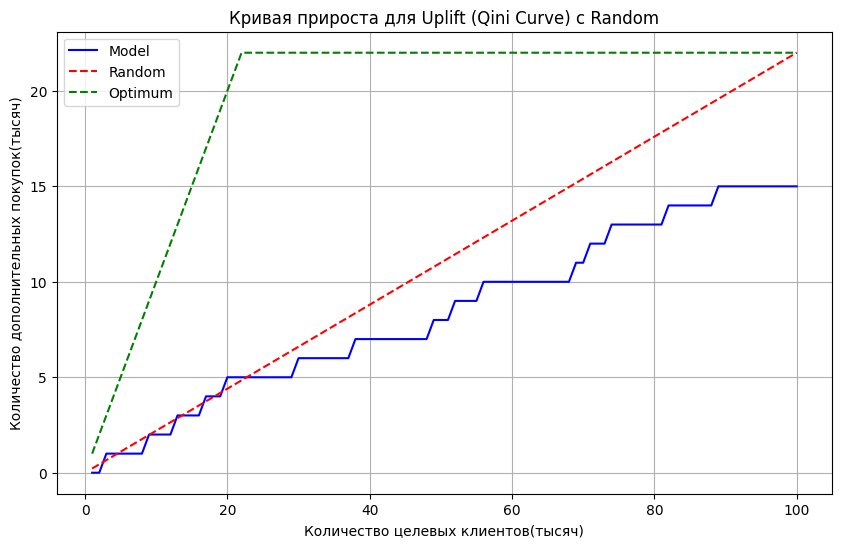

In [16]:
# построение графиков
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cgain) + 1), cgain, label='Model', color='blue')
plt.plot(range(1, len(random) + 1), random, label='Random', color='red', linestyle='--')
plt.plot(range(1, len(optimum) + 1), optimum, label='Optimum', color='green', linestyle='--')
plt.xlabel('Количество целевых клиентов(тысяч)')
plt.ylabel('Количество дополнительных покупок(тысяч)')
plt.title('Кривая прироста для Uplift (Qini Curve) с Random')
plt.legend()
plt.grid(True)
plt.show()

Qini Score: -264.39 указывает на то, что производительность модели значительно хуже, чем случайный отбор. В контексте uplift-моделирования отрицательный Qini Score говорит о том, что предсказания модели неэффективно определяют пользователей, которые бы получили наибольший прирост от воздействия. Такие предсказания даже могут вызывать отрицательный uplift, чего бы не произошло, если бы модель не использовалась вовсе. Это говорит о том, что необходимо улучшить точность модели в предсказании uplift.

## Задание

In [19]:
%matplotlib inline
# загружаем DataFrame
discount = pd.read_csv("discountuplift.csv", sep="\t")
discount.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
0,3,977.51,1,1,1,0,0,0,1,0,0,1,0.476095,0.159710,0.280660,0.083534,-0.043654,0
1,4,391.10,1,0,0,0,1,0,0,1,0,0,0.443035,0.087289,0.285081,0.184594,0.456858,0
2,7,72.37,1,0,1,1,0,0,1,0,0,1,0.514386,0.015488,0.429174,0.040952,0.115756,2
3,10,67.40,1,0,0,1,0,0,1,0,0,1,0.386800,0.125233,0.415839,0.072128,-0.193534,2
4,2,45.68,1,0,1,1,0,0,1,0,1,0,0.517491,0.022507,0.412372,0.047630,0.123726,2


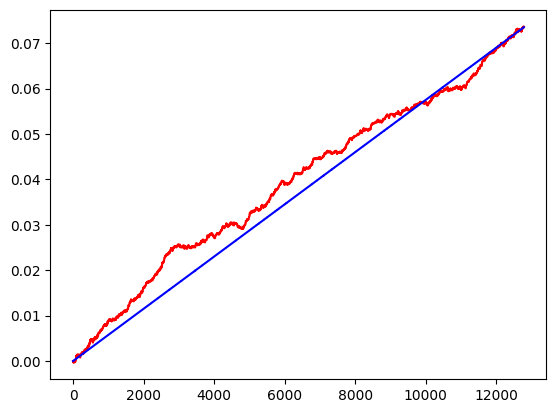

33.17995

In [20]:
# реализуем подсчёт Qini Score:
def qini_df(df):
    # 1. Отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked["n_t1/nt"] - ranked["n_c1/nc"], 5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(
        ranked["uplift_score"].rank(pct=True, ascending=False)
        * ranked["uplift"].iloc[-1],
        5,
    )
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

qini_df(discount)

## Пример проведения A/B-теста для uplift-моделирования

In [ ]:
# загрузим данные пользователей
data = pd.read_csv(FILENAME)

# добавим колонку с группой (контрольная или экспериментальная)
np.random.seed(42)  # для воспроизводимости результатов
data['group'] = np.random.choice(['control', 'experiment'], size=len(data))

# сохраним контрольную и экспериментальную группы в отдельные переменные
control_group = data[data['group'] == 'control']
experiment_group = data[data['group'] == 'experiment'] 

In [ ]:
# добавим колонку с информацией о скидках
data['discount'] = np.where(data['group'] == 'experiment', True, False)

# проверим результат
print(data.head())

In [ ]:
# создадим DataFrame для хранения результатов теста
results = pd.DataFrame(columns=['user_id', 'group', 'num_rides', 'total_spent'])

# симуляция данных для каждой группы
# для простоты примера мы используем случайные данные
for _, row in data.iterrows():
    num_rides = np.random.poisson(lam=5 if row['discount'] else 3)  # предполагаем, что скидки увеличивают среднее количество поездок
    total_spent = num_rides * (20 if row['discount'] else 25)  # допустим, что средняя стоимость поездки отличается
    
    results = results.append({
        'user_id': row['user_id'],
        'group': row['group'],
        'num_rides': num_rides,
        'total_spent': total_spent
    }, ignore_index=True)

# сохраним результаты
results.to_csv('ab_test_results.csv', index=False)

In [ ]:
#После завершения теста анализируются собранные данные:
#сравниваются результаты контрольной и экспериментальной групп;
#оценивается, насколько значимо увеличилось количество поездок в экспериментальной группе;
#применяются статистические тесты для определения значимости различий.

from scipy import stats
  
# загрузим результаты теста
results = pd.read_csv('ab_test_results.csv')

# группируем данные
grouped_results = results.groupby('group').agg({
    'num_rides': ['mean', 'std', 'count'],
    'total_spent': ['mean', 'std', 'count']
})

print(grouped_results)

# сравниваем средние значения количества поездок
control_rides = results[results['group'] == 'control']['num_rides']
experiment_rides = results[results['group'] == 'experiment']['num_rides']

t_stat, p_value = stats.ttest_ind(control_rides, experiment_rides)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

# оцениваем, насколько значимо увеличилось количество поездок в экспериментальной группе
if p_value < 0.05:
    print("Различие в количестве поездок между контрольной и экспериментальной группами статистически значимо.")
else:
    print("Различие в количестве поездок между контрольной и экспериментальной группами не является статистически значимым.")


## S-lern

In [24]:
df = pd.read_csv("discountuplift.csv", sep="\t")
df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
0,3,977.51,1,1,1,0,0,0,1,0,0,1,0.476095,0.159710,0.280660,0.083534,-0.043654,0
1,4,391.10,1,0,0,0,1,0,0,1,0,0,0.443035,0.087289,0.285081,0.184594,0.456858,0
2,7,72.37,1,0,1,1,0,0,1,0,0,1,0.514386,0.015488,0.429174,0.040952,0.115756,2
3,10,67.40,1,0,0,1,0,0,1,0,0,1,0.386800,0.125233,0.415839,0.072128,-0.193534,2
4,2,45.68,1,0,1,1,0,0,1,0,1,0,0.517491,0.022507,0.412372,0.047630,0.123726,2


In [72]:
df['old_target'] = df['target_class'] - 1

feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']
target_col = 'old_target'
treatment_col = 'treatment'

In [73]:
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(df, test_size=0.25, random_state=1)

In [74]:
# доля значений 1 в целевой переменной из тренировочного датасета
round(df_test[df_test['old_target'] == 1].shape[0] / df_test.shape[0], 5)

0.41176

In [75]:
from sklearn.linear_model import LogisticRegression

s_learner = LogisticRegression(random_state=1)
s_learner.fit(X=df_train[feature_cols + [treatment_col]],
              y=df_train[target_col])

# посчитайте intercept
print(s_learner.intercept_)

[ 0.63455629 -0.33398855  0.07575224 -0.37631997]


In [64]:
#pip install scikit-uplift

In [ ]:
# предскажем вероятность покупки, если скидка есть
df_test[treatment_col] = 1
df_test['yes_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]

# предскажите вероятность покупки, если скидки нет 
df_test[treatment_col] = 0
df_test['no_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]

# посчитаем uplift на объектах тестовой выборки
uplift_vals = df_test['yes_treatment'] - df_test['no_treatment']
df_test['uplift_score'] = uplift_vals

# Посчитаем Qini Score (используем библиотеку `sklift`)
from sklift.metrics import qini_auc_score

qini = qini_auc_score(df_test[target_col], df_test['uplift_score'], df_test[treatment_col])

print("Qini Score:", qini)

ValueError: Input array is not binary. Array should contain only int or float binary values 0 (or 0.) and 1 (or 1.). Got values [0].